<a id='index'></a>
# __Feature Selection with Genetic Function Approximation (GFA)__

### Contents:
* [Loading Data](#data)
* [Auxiliar Functions](#functions)
* [GFA](#gfa)

----------------
<a id='data'></a>
## __Loading Data__
[Back To Top](#index)

In [21]:
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import time
import seaborn as sns
import warnings
from statsmodels import api
import math
from scipy.optimize import minimize
import scipy.stats as stats
import pandas as pd
import statsmodels. api as sm
import matplotlib.pyplot as plt
import random
random.seed(42)
from random import choices, randint, randrange

from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

data = pd.read_excel('data.xlsx')
data.head()

,x1,x2,x3,x4,y
0,0.0,2.318975,0.000000,0.000000,1.96
1,0.0,3.320746,0.000000,0.000000,8.35
2,0.0,1.136464,1.510941,0.667490,11.90
3,0.0,1.241205,1.494163,0.678460,11.43
4,0.0,0.553377,0.357283,0.162193,6.41


In [22]:
ingredients = ['x1', 'x2','x3', 'x4']
properties = ['y']

# Removing Outliers
z = np.abs(stats.zscore(data))
data = data[(z<3).all(axis=1)]

# Defining Interaction Terms
intercationterms = []
for i in range(len(ingredients)):
    for t in ingredients[i+1:]:
        term = f"{ingredients[i]}*{t}"
        intercationterms.append(term)
        data[term] = data[ingredients[i]] * data[t]

cols = list(data.columns)
cols.remove('y')

X = data[cols]
y = data['y']

print("Data: ", data.shape)
print("X: ", X.shape)
print("y: ", y.shape)

X.to_numpy()
y.to_numpy()

Data:  (26, 11)
X:  (26, 10)
y:  (26,)


array([ 1.96 ,  8.35 , 11.9  , 11.43 ,  6.41 , 10.88 , 23.4  ,  4.04 ,
       20.925,  1.05 , 13.8  ,  6.44 ,  9.02 ,  0.08 ,  0.97 ,  3.58 ,
        0.75 ,  6.6  ,  6.6  , 12.4  , 13.6  , 22.7  , 22.3  , 34.6  ,
       23.4  , 14.26 ])

In [23]:
censors = {'y': [0, +math.inf]}

l_censor=censors['y'][1]
r_censor=censors['y'][0]

--------------------
<a id='functions'></a>
## __Auxiliar Functions__
[Back To Top](#index)

### __Maximum Likelihood Estimation__

In [24]:
def mylnPhi_aux(xs):
    return -0.5*xs*xs - np.log(abs(xs)*math.sqrt(0.125*math.pi))

# For right censored data
def mylnPhi(x, cut=-30):
    const = np.log(stats.norm.cdf(cut))-mylnPhi_aux(cut)
    smaller_cut = x < cut
    y = np.full((len(x)), np.nan)
    if any(smaller_cut):
        y[smaller_cut] = const + mylnPhi_aux(x[smaller_cut])
    if any(~smaller_cut):
        y[~smaller_cut] = np.log(stats.norm.cdf(x[~smaller_cut]))
    return y

# For left censored data
def myln1_Phi(x, cut=7):
    const = np.log(stats.norm.cdf(-cut)) - mylnPhi_aux(cut)
    larger_cut = x > cut
    y = np.full((len(x)), np.nan)
    if any(larger_cut):
        y[larger_cut] = const + mylnPhi_aux(x[larger_cut])
    if any(~larger_cut):
        y[~larger_cut] = np.log(1 - stats.norm.cdf(x[~larger_cut]))
    return y

def logli(theta, y, X, left_censor=+math.inf, right_censor=-math.inf):
    right_censored = y <= right_censor
    left_censored = y >= left_censor
    non_censored = (~right_censored) & (~left_censored)
    sigma = theta[0]
    betas = theta[1:]
    mus = betas[0] + np.dot(X,betas[1:])
    rv = -sum(non_censored)*(0.9189385 + math.log(sigma))
    # 0.5*log(2*pi) ~ 0.9189385
    inv_sigma = 1/sigma

    if any(non_censored):
        res = y[non_censored] - mus[non_censored]
        res = res*inv_sigma
        rv = rv - 0.5*sum(res*res)

    if any(right_censored):
        res = y[right_censored] - mus[right_censored]
        res = res*inv_sigma
        rv = rv + sum(mylnPhi(res))

    if any(left_censored):
        res = y[left_censored] - mus[left_censored]
        res = res*inv_sigma
        rv = rv + sum(myln1_Phi(res))

    return -rv

In [25]:
def MLE(X, y):
    # Getting initial guess for the parameters
    features = api.add_constant(X)
    model = api.OLS(y, features).fit()
    res = model.resid
    standard_dev = np.std(res)
    
    n_fs=len(X.T)
    
    #theta = np.arange(1, nr_col+2+1, 1), one param for each column, one for const, one sigma
    theta = np.full(n_fs+2, standard_dev)
    
    bnds = [(0.0001, math.inf)] + [(-math.inf, math.inf) for i in range(n_fs+1)]
    
    loglipar = minimize(logli,
                    theta,
                    args=(y, X, l_censor, r_censor),
                    method = 'L-BFGS-B',
                    bounds=bnds,
                    options={"maxiter":10000}
                   )
    return loglipar

### __AIC, AICC, and BIC__

In [26]:
# K - num of parameters = num feats + constant + sigma
# LL - log likelihood
# n - number of obs
def aic_function(n_fs, LL):
    k = n_fs + 2
    return 2*k -2*LL

def aicc_function(n_fs, LL, n):
    k = n_fs+2
    return aic_function(k,LL) + ((2*k**2 + 2*k)/(n-k-1))

def bic_function(n_fs, LL, n):
    k = n_fs + 2
    return k*np.log(n) - 2*LL

--------------------
<a id='gfa'></a>
## __Genetic Function Approximation (GFA)__
[Back To Top](#index)

### __Auxiliar Functions__

In [27]:
# Step 1: generate genome
def generate_genome(length: int): 
    return choices([True,False], k=length)

# Step 2: generate population of genomes
def generate_population(population_size: int, genome_length:int):
    return [generate_genome(genome_length) for _ in range(population_size)]

# Step 3: generate fitness function
def fitness(genome, X, y, method="AIC"):
    
    cut_X = X[X.columns[genome]]
    
    neg_LL_model = MLE(cut_X, y)
    
    n_fs = len(cut_X.T)
    LL = -neg_LL_model.fun
    n = len(cut_X)
    
    if method == "AIC":
        score = aic_function(n_fs, LL)
        
    elif method == "AICc":
        score = aicc_function(n_fs, LL, n)
        
    if method == "BIC":
        score = bic_function(n_fs, LL, n)
        
    return score

# Step 4: selection function
def select_pair(population, fitness):
    return choices(
        population=population,
        weights = [fitness(genome, X, y) for genome in population],
        k=2 # draw twos to get a pair
    )

# Step 5: crossover function
def single_point_crossover(a, b):
    length = len(a)
    if length <2:
        return a,b
    
    p = randint(1, length -1)
    return a[0:p] + b[p:], b[0:p] + a[p:]

# Step 6: mutation function
def mutation(genome, num: int=1, probability: float = 0.5):
    for _ in range(num):
        # choose a random index
        index = randrange(len(genome))
        
        if random.random() > probability:
            genome[index] = genome[index]  
        else:
            # genome1 = [True, False, True]
            # genome1[0]=genome1[0]==False
            # genome1[1]=genome1[1]==False
            genome[index]=genome[index]==False
    return genome

### __GFA Function__

In [28]:
def genetic_feature_selection(
    X,
    y,
    generation_limit = 20,
    population_size = 10,
    scoring_method = "AIC",
    mutation_func=mutation,
    mutation = True,
    elitism = True
):
    # first generation
    population = generate_population(population_size, len(X.T))
    
    generation_fitness = []
    
    for i in range(generation_limit):
        
        print(f'=== Generation {i} ===')
        population = sorted(population, key=lambda genome: fitness(genome, X, y, scoring_method))
        
        generation_fitness.append(fitness(population[0], X, y, scoring_method))
        
        if elitism == True:
            next_generation = population[0:2] # keep top two solutions for next generation
        
            # loop for half of the generation
            for j in range(int(len(population) / 2) - 1):
                parents = select_pair(population, fitness)
                offsprings = single_point_crossover(parents[0], parents[1])
                
                if mutation == True:
                    offspring_a = mutation_func(offsprings[0])
                    offspring_b = mutation_func(offsprings[1])
                else:
                    offspring_a = offsprings[0]
                    offspring_b = offsprings[1]
                    
                next_generation += [offspring_a, offspring_b]
        else:
            # loop for half of the generation
            for j in range(int(len(population) / 2)):
                parents = select_pair(population, fitness)
                offsprings = single_point_crossover(parents[0], parents[1])
                
                if mutation == True:
                    offspring_a = mutation_func(offsprings[0])
                    offspring_b = mutation_func(offsprings[1])
                else:
                    offspring_a = offsprings[0]
                    offspring_b = offsprings[1]
                    
                next_generation += [offspring_a, offspring_b]
                
        population = next_generation
        
    population = sorted(
        population,
        key=lambda genome: fitness(genome, X, y, scoring_method),
    )
        
    return population, generation_fitness

In [29]:
start = time.time()

gfa_20_10, scores_20_10 = genetic_feature_selection(X, y, generation_limit = 20, population_size = 10, mutation = True, elitism = True)

end = time.time()

print("Running Time: ", end - start)

=== Generation 0 ===
=== Generation 1 ===
=== Generation 2 ===
=== Generation 3 ===
=== Generation 4 ===
=== Generation 5 ===
=== Generation 6 ===
=== Generation 7 ===
=== Generation 8 ===
=== Generation 9 ===
=== Generation 10 ===
=== Generation 11 ===
=== Generation 12 ===
=== Generation 13 ===
=== Generation 14 ===
=== Generation 15 ===
=== Generation 16 ===
=== Generation 17 ===
=== Generation 18 ===
=== Generation 19 ===
Running Time:  524.1766064167023


In [30]:
print("Best genome: ", gfa_20_10[0])
print("Fitness of best genome: ", scores_20_10[-1])

Best genome:  [True, False, True, True, True, True, False, False, True, False]
Fitness of best genome:  173.02611639846614


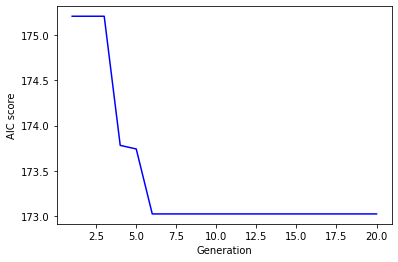

In [31]:
plt.plot([i+1 for i in range(len(scores_20_10))], scores_20_10, color = 'b')
plt.xlabel('Generation')
plt.ylabel('AIC score')
plt.show()

In [32]:
start = time.time()

gfa_50_20, scores_50_20 = genetic_feature_selection(X, y, generation_limit = 50, population_size = 20, mutation = True,elitism = True)

end = time.time()

print("Running Time: ", end - start)

=== Generation 0 ===
=== Generation 1 ===
=== Generation 2 ===
=== Generation 3 ===
=== Generation 4 ===
=== Generation 5 ===
=== Generation 6 ===
=== Generation 7 ===
=== Generation 8 ===
=== Generation 9 ===
=== Generation 10 ===
=== Generation 11 ===
=== Generation 12 ===
=== Generation 13 ===
=== Generation 14 ===
=== Generation 15 ===
=== Generation 16 ===
=== Generation 17 ===
=== Generation 18 ===
=== Generation 19 ===
=== Generation 20 ===
=== Generation 21 ===
=== Generation 22 ===
=== Generation 23 ===
=== Generation 24 ===
=== Generation 25 ===
=== Generation 26 ===
=== Generation 27 ===
=== Generation 28 ===
=== Generation 29 ===
=== Generation 30 ===
=== Generation 31 ===
=== Generation 32 ===
=== Generation 33 ===
=== Generation 34 ===
=== Generation 35 ===
=== Generation 36 ===
=== Generation 37 ===
=== Generation 38 ===
=== Generation 39 ===
=== Generation 40 ===
=== Generation 41 ===
=== Generation 42 ===
=== Generation 43 ===
=== Generation 44 ===
=== Generation 45 ==

In [33]:
print("Best genome: ", gfa_50_20[0])
print("Fitness of best genome: ", scores_50_20[-1])

Best genome:  [True, False, True, False, True, True, False, False, True, False]
Fitness of best genome:  171.0924359382567


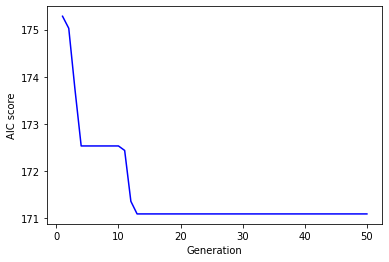

In [34]:
plt.plot([i+1 for i in range(len(scores_50_20))], scores_50_20, color = 'b')
plt.xlabel('Generation')
plt.ylabel('AIC score')
plt.show()

In [65]:
start = time.time()

gfa_80_30, scores_80_30 = genetic_feature_selection(X, y, generation_limit = 80, population_size = 30, mutation = True,elitism = True)

end = time.time()

print("Running Time: ", end - start)

=== Generation 0 ===
=== Generation 1 ===
=== Generation 2 ===
=== Generation 3 ===
=== Generation 4 ===
=== Generation 5 ===
=== Generation 6 ===
=== Generation 7 ===
=== Generation 8 ===
=== Generation 9 ===
=== Generation 10 ===
=== Generation 11 ===
=== Generation 12 ===
=== Generation 13 ===
=== Generation 14 ===
=== Generation 15 ===
=== Generation 16 ===
=== Generation 17 ===
=== Generation 18 ===
=== Generation 19 ===
=== Generation 20 ===
=== Generation 21 ===
=== Generation 22 ===
=== Generation 23 ===
=== Generation 24 ===
=== Generation 25 ===
=== Generation 26 ===
=== Generation 27 ===
=== Generation 28 ===
=== Generation 29 ===
=== Generation 30 ===
=== Generation 31 ===
=== Generation 32 ===
=== Generation 33 ===
=== Generation 34 ===
=== Generation 35 ===
=== Generation 36 ===
=== Generation 37 ===
=== Generation 38 ===
=== Generation 39 ===
=== Generation 40 ===
=== Generation 41 ===
=== Generation 42 ===
=== Generation 43 ===
=== Generation 44 ===
=== Generation 45 ==

In [66]:
print("Best genome: ", gfa_80_30[0])
print("Fitness of best genome: ", scores_80_30[-1])

Best genome:  [True, False, True, False, False, True, True, False, False, False, True, False, False, True, False]
Fitness of best genome:  160.06392347429366


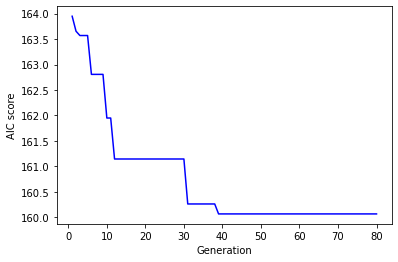

In [103]:
plt.plot([i+1 for i in range(len(scores_80_30))], scores_80_30, color = 'b')
plt.xlabel('Generation')
plt.ylabel('AIC score')
plt.show()